[CNN] Epoch=400, Train=0.000476, Val=0.001121
[CNN] Epoch=600, Train=0.000448, Val=0.001109
Early stopping triggered
[CNN] Early stopping at epoch 635
CNN has no real test data => skip MAPE

=== Training Transformer model ===


/tmp/ipykernel_982785/2527630289.py:461: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))
/home/yuzhe/.local/l

Early stopping triggered
[Transformer] Early stopping at epoch 100


/tmp/ipykernel_982785/2527630289.py:461: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


Transformer has no real test data => skip MAPE

=== Training N-BEATS model ===
[N-BEATS] Epoch=200, Train=0.000868, Val=0.001722
[N-BEATS] Epoch=400, Train=0.001191, Val=0.005350
Early stopping triggered
[N-BEATS] Early stopping at epoch 465


/tmp/ipykernel_982785/2527630289.py:461: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


N-BEATS has no real test data => skip MAPE

=== Training N-HITS model ===
[N-HITS] Epoch=200, Train=0.000890, Val=0.001985
[N-HITS] Epoch=400, Train=0.002023, Val=0.004755
Early stopping triggered
[N-HITS] Early stopping at epoch 455


/tmp/ipykernel_982785/2527630289.py:461: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


N-HITS has no real test data => skip MAPE

=== Training SVM model ===
SVM has no real test data => skip MAPE

=== Training GPR model ===
GPR has no real test data => skip MAPE

=== Training Boost model ===
Boost has no real test data => skip MAPE


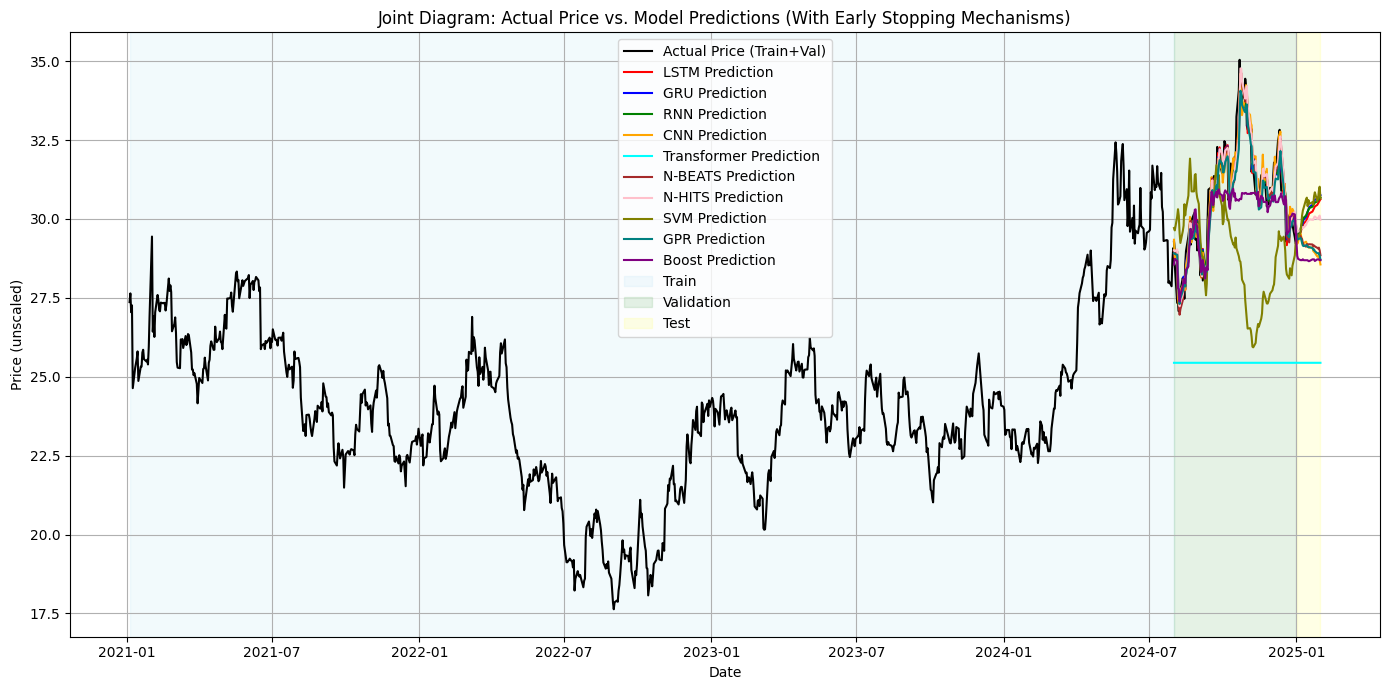

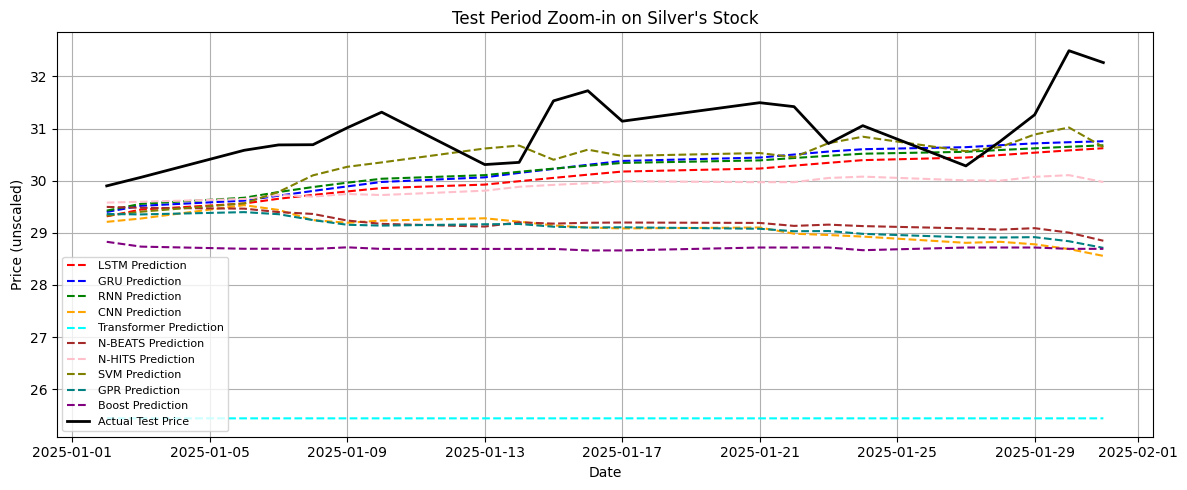

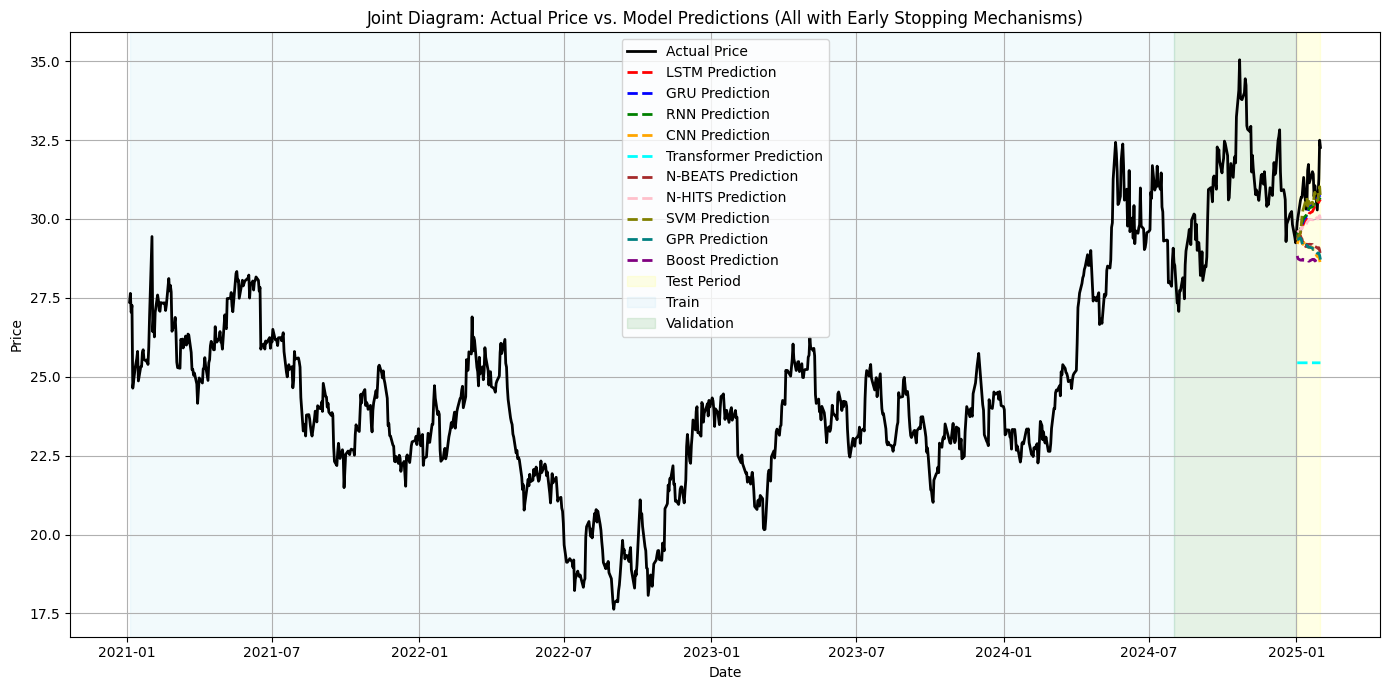

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib
import torch.backends.cudnn as cudnn

# Additional imports for sklearn-based models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor

# For Gradient Boosting with early_stopping in scikit-learn 0.21+:
from sklearn.ensemble import GradientBoostingRegressor

###############################################################################
# 1. Setup: random seeds + CuDNN benchmark
###############################################################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    cudnn.benchmark = True  # Let CuDNN pick the fastest algorithm for your GPU

###############################################################################
# Global hyperparameters
###############################################################################
WINDOW_SIZE = 35
NUM_EPOCHS  = 2000  # e.g. 1200
features = ["Price", "Open", "High", "Low"]
csv_file = "Silver Futures Historical Data.csv"

###############################################################################
# 2. Load & Clean CSV
###############################################################################
df = pd.read_csv(csv_file)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows with all features = NaN:", df[features].isna().all(axis=1).sum())

###############################################################################
# 3. Date cutoffs: TRAIN, VAL, TEST
###############################################################################
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

###############################################################################
# 4. Fit MinMaxScaler on TRAIN only
###############################################################################
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])
val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])
train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

###############################################################################
# 5A. Create the training sequences
###############################################################################
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

df_train_nonan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(df_train_nonan, window=WINDOW_SIZE)
X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset,
    batch_size=len(train_dataset),  # single-batch approach
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

# For sklearn-based models, flatten the time window
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))

###############################################################################
# 5B. "Half-blind" validation loss function
###############################################################################
import torch.nn.functional as F

def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    criterion = nn.MSELoss()
    
    model.eval()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features].values.astype(float)
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

###############################################################################
# 5C. "Half-blind" validation predictions (non-iterative)
###############################################################################
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current)==0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx<0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df= window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data= window_df.values
            if np.isnan(window_data).any():
                continue
            X_input=torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled= model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df= pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array= pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unsc_array= inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"] = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"] = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"] = unsc_array[:, 3]
    return pred_df

###############################################################################
# Iterative (next-day) half-blind validation predictions
###############################################################################
def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask= (df_work["Date"]>= val_start) & (df_work["Date"]<= val_end)
    val_dates= np.sort(df_work.loc[val_mask, "Date"].unique())
    
    val_idx= df_work.index[df_work["Date"]>= val_start]
    if len(val_idx)==0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx= val_idx[0]
    
    current_window= df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds=[]
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            X_input= torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled= model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            actual_row= df_work[df_work["Date"]== d][features].values
            if actual_row.shape[0]==0:
                continue
            actual= actual_row[0]
            current_window= np.vstack((current_window[1:], actual))
    
    pred_df= pd.DataFrame(
        preds,
        columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    
    scl_array= pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unsc_array= inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"]= unsc_array[:,0]
    pred_df["Pred_Open_unscaled"]= unsc_array[:,1]
    pred_df["Pred_High_unscaled"]= unsc_array[:,2]
    pred_df["Pred_Low_unscaled"]= unsc_array[:,3]
    return pred_df

###############################################################################
# 6. Define the base PyTorch model
###############################################################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=WINDOW_SIZE):
        super().__init__()
        self.model_type= model_type
        self.window_width= window_width
        hidden_size=128
        
        if model_type=="CNN":
            self.conv1= nn.Conv1d(in_channels=4,out_channels=64,kernel_size=3)
            self.conv2= nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3)
            with torch.no_grad():
                dummy_input= torch.zeros(1,4,self.window_width)
                dummy_output= self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size= dummy_output.shape[1]* dummy_output.shape[2]
            self.fc= nn.Linear(conv_output_size,4)
        elif model_type=="LSTM":
            self.rnn= nn.LSTM(input_size=4, hidden_size=hidden_size, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc= nn.Linear(hidden_size,4)
        elif model_type=="GRU":
            self.rnn= nn.GRU(input_size=4, hidden_size=hidden_size, num_layers=2,
                             batch_first=True, dropout=0.1)
            self.fc= nn.Linear(hidden_size,4)
        elif model_type=="RNN":
            self.rnn= nn.RNN(input_size=4, hidden_size=hidden_size, num_layers=2,
                             batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc= nn.Linear(hidden_size,4)
        elif model_type=="EnhancedLSTM":
            self.rnn= nn.LSTM(input_size=4, hidden_size=hidden_size, num_layers=3,
                              batch_first=True, dropout=0.2)
            self.bn= nn.BatchNorm1d(hidden_size)
            self.dropout= nn.Dropout(0.2)
            self.fc= nn.Linear(hidden_size,4)
        elif model_type=="Transformer":
            self.input_linear= nn.Linear(4,hidden_size)
            encoder_layer= nn.TransformerEncoderLayer(d_model=hidden_size, nhead=8, dropout=0.1)
            self.transformer_encoder= nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc= nn.Linear(hidden_size,4)
        elif model_type=="N-BEATS":
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([ nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        elif model_type=="N-HITS":
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([ nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type=="CNN":
            x= x.permute(0,2,1)
            x= F.relu(self.conv1(x))
            x= F.relu(self.conv2(x))
            x= x.view(x.size(0), -1)
            out= self.fc(x)
        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _= self.rnn(x)
            out= out[:, -1, :]
            out= self.fc(out)
        elif self.model_type=="EnhancedLSTM":
            out, _= self.rnn(x)
            out= out[:, -1, :]
            out= self.bn(out)
            out= self.dropout(out)
            out= self.fc(out)
        elif self.model_type=="Transformer":
            x= self.input_linear(x)
            x= x.permute(1,0,2)
            x= self.transformer_encoder(x)
            x= x[-1, :, :]
            out= self.fc(x)
        elif self.model_type in ["N-BEATS","N-HITS"]:
            x_flat= x.reshape(x.size(0), -1)
            forecast=0
            for block in self.blocks:
                forecast= forecast + block(x_flat)
            out= forecast
        else:
            raise ValueError("Invalid model_type")
        return out

###############################################################################
# Early Stopping class for PyTorch
###############################################################################
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > (self.best_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

###############################################################################
# 7. Inverse transform helper
###############################################################################
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

###############################################################################
# 8. PyTorch model training with Early Stopping
###############################################################################
def train_model(model_type="LSTM", num_epochs=NUM_EPOCHS):
    """
    This function trains a PyTorch model on GPU (if available) with early stopping
    at the validation set. We validate every 5 epochs, but only print logs every 100.
    """
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    best_path = f"best_{model_type}_Silver_V5.pt"
    
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return model

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.005)
    
    # We reduce LR on plateau:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=15, factor=0.5)
    
    # Early stopping with patience=10
    early_stopping = EarlyStopping(patience=15)
    
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        
        # Validate every 5 epochs
        if (epoch + 1) % 5 == 0:
            val_loss = half_blind_validation_loss(
                model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE
            )
            scheduler.step(val_loss)
            early_stopping(val_loss)
            
            # Update best model if improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_path)
            
            # Print logs only every 100 epochs
            if (epoch + 1) % 200 == 0:
                print(f"[{model_type}] Epoch={epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
            
            # Early stop if triggered
            if early_stopping.early_stop:
                print(f"[{model_type}] Early stopping at epoch {epoch+1}")
                break
    
    if os.path.exists(best_path):
        model.load_state_dict(torch.load(best_path, map_location=device))
    return model

###############################################################################
# 8B. scikit-learn-based models with "early stopping" where possible
###############################################################################
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    
    def forward(self, x):
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1,4)
        return torch.from_numpy(pred).float().to(x.device)
    
    def eval(self):
        pass
    
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    """
    For GradientBoostingRegressor, we demonstrate scikit-learn's internal
    early stopping (n_iter_no_change, validation_fraction).
    For SVM, GPR => no built-in early stopping or GPU usage in standard scikit-learn.
    """
    best_path = f"best_{model_type}_Silver_V5.pkl"
    
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return SklearnWrapper(model)
    
    if model_type == "SVM":
        # SVM has no built-in early-stopping in standard scikit-learn
        base_model = SVR(kernel='rbf', C=10.0, epsilon=0.01, max_iter=-1)
        # Will train on CPU
    elif model_type == "GPR":
        # GPR doesn't do iterative training => no "early stopping"
        from sklearn.gaussian_process.kernels import RBF
        kernel = RBF(length_scale=1.0)
        base_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
    elif model_type == "Boost":
        # We can do built-in early stopping with 'n_iter_no_change' param
        # and 'validation_fraction' in sklearn >= 0.21
        base_model = GradientBoostingRegressor(
            n_estimators=5000,           # a large upper bound
            max_depth=3,
            learning_rate=0.05,
            subsample=0.8,
            validation_fraction=0.1,
            n_iter_no_change=10,        # stop if no improvement for 10 iterations
            tol=1e-4
        )
    else:
        raise ValueError("Unsupported sklearn model type")
    
    multi_model = MultiOutputRegressor(base_model)
    multi_model.fit(X_train_flat, y_train)
    
    joblib.dump(multi_model, best_path)
    return SklearnWrapper(multi_model)

###############################################################################
# 9. Test-time predictions (walk-forward)
###############################################################################
def walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    
    model.eval()  # for PyTorch, does nothing for sklearn
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current)==0:
                continue
            idx_current= idx_current[0]
            start_idx= idx_current- window
            if start_idx<0:
                continue
            window_df= df_work.iloc[start_idx:idx_current][features]
            window_df= window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data= window_df.values
            if np.isnan(window_data).any():
                continue
            
            X_input= torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled= model(X_input).cpu().numpy()[0]
            
            # Overwrite row with the predicted scaled values
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))
    
    pred_df= pd.DataFrame(
        preds,
        columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    
    scl_array= pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unsc_array= inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"]= unsc_array[:,0]
    pred_df["Pred_Open_unscaled"]= unsc_array[:,1]
    pred_df["Pred_High_unscaled"]= unsc_array[:,2]
    pred_df["Pred_Low_unscaled"]= unsc_array[:,3]
    return pred_df

###############################################################################
# 10. Evaluate & Plot
###############################################################################
def evaluate_and_plot_all_models(results_dict):
    df_real= df_scaled[["Date","Price","Open","High","Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    
    mask_trainval= (df_real["Date"]< test_cutoff)
    df_real_plot= df_real.loc[mask_trainval].copy()
    real_4_scaled= df_real_plot[features].values
    real_4_unscaled= inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"]= real_4_unscaled[:,0]
    
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    color_map= {
        "LSTM":"red",
        "GRU":"blue",
        "RNN":"green",
        "CNN":"orange",
        "EnhancedLSTM":"magenta",
        "Transformer":"cyan",
        "N-BEATS":"brown",
        "N-HITS":"pink",
        "SVM":"olive",
        "GPR":"teal",
        "Boost":"purple"
    }
    
    merged_df= df_real.copy()
    merged_df.sort_values("Date",inplace=True)
    
    for model_name, info in results_dict.items():
        val_pred_df= info["val_pred_df"]
        test_pred_df= info["test_pred_df"]
        
        frames= []
        if val_pred_df is not None:
            frames.append(
                val_pred_df.rename(columns={"Pred_Price_unscaled":f"Pred_{model_name}"})
            )
        if test_pred_df is not None:
            frames.append(
                test_pred_df.rename(columns={"Pred_Price_unscaled":f"Pred_{model_name}"})
            )
        if not frames:
            continue
        
        combined_df= pd.concat(frames, ignore_index=True)
        combined_df= combined_df[["Date",f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df= pd.merge(merged_df, combined_df, on="Date", how="left")
    
    # Plot each model
    for model_name, info in results_dict.items():
        col= f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name,"gray"),
                     linestyle="-",
                     label=f"{model_name} Prediction")
    
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    
    plt.title("Joint Diagram: Actual Price vs. Model Predictions (With Early Stopping Mechanisms)")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Zoom-in on test period
    df_test_zoom= merged_df[merged_df["Date"]>= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name, info in results_dict.items():
            col= f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[col],
                         color=color_map.get(model_name,"gray"),
                         linestyle="--", label=f"{model_name} Prediction")
        
        # Load actual test data from a "complete" CSV
        df_complete= pd.read_csv("Silver Futures Historical Data_Complete.csv")
        df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
        df_complete["Date"]= pd.to_datetime(df_complete["Date"])
        df_complete.sort_values("Date", inplace=True)
        df_test_actual= df_complete[df_complete["Date"]>= test_cutoff].copy()
        
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color="black", linewidth=2, label="Actual Test Price")
        
        plt.title("Test Period Zoom-in on Silver's Stock")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend(prop={"size":8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

###############################################################################
# 11. MAIN
###############################################################################
if __name__=="__main__":
    all_model_types= ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "GPR", "Boost"]
    results_dict= {}
    
    for mt in all_model_types:
        print(f"\n=== Training {mt} model ===")
        if mt in ["SVM","GPR","Boost"]:
            # scikit-learn based (CPU, but has early_stopping for Boost)
            model= train_model_sklearn(mt, X_train_flat, y_train_all)
            
            # For demonstration, we do iterative (next-day) validation for these
            if mt in ["Boost", "Transformer"]:  # or we can use half_blind
                val_pred_df= iterative_half_blind_validation_preds(
                    model,
                    df_scaled,
                    val_start=train_cutoff,
                    val_end=val_cutoff,
                    window=WINDOW_SIZE
                )
            else:
                val_pred_df= half_blind_validation_preds_df(
                    model,
                    df_scaled,
                    val_start=train_cutoff,
                    val_end=val_cutoff,
                    window=WINDOW_SIZE
                )
        else:
            # PyTorch-based, on GPU if available
            model= train_model(mt, num_epochs=NUM_EPOCHS)
            
            # Typically do half-blind for these
            val_pred_df= half_blind_validation_preds_df(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        
        # Test predictions
        test_pred_df= walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )
        
        results_dict[mt]= {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} has no real test data => skip MAPE")
    
    evaluate_and_plot_all_models(results_dict)

# ================================
# Additional Plot: Joint Diagram
# ================================
df_actual= pd.read_csv("Silver Futures Historical Data_Complete.csv")
df_actual.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
df_actual["Date"]= pd.to_datetime(df_actual["Date"])
df_actual.sort_values("Date", ascending=True, inplace=True)
df_actual.reset_index(drop=True, inplace=True)

# Clean numeric columns
num_cols= df_actual.columns.drop("Date")
df_actual[num_cols]= df_actual[num_cols].replace({",":""}, regex=True)
df_actual[num_cols]= df_actual[num_cols].astype("float64")

actual_dates= df_actual["Date"]
actual_prices= df_actual["Price"]

import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(actual_dates, actual_prices, color="black", linewidth=2, label="Actual Price")

model_colors= {
    "LSTM":"red",
    "GRU":"blue",
    "RNN":"green",
    "CNN":"orange",
    "Transformer":"cyan",
    "N-BEATS":"brown",
    "N-HITS":"pink",
    "SVM":"olive",
    "GPR":"teal",
    "Boost":"purple"
}

for model_name, pred_info in results_dict.items():
    test_df= pred_info["test_pred_df"]
    if test_df is not None and not test_df.empty:
        plt.plot(pd.to_datetime(test_df["Date"]), test_df["Pred_Price_unscaled"],
                 color=model_colors.get(model_name,"gray"),
                 linestyle="--", linewidth=2,
                 label=f"{model_name} Prediction")

test_period_start= pd.to_datetime("2025-01-02")
plt.axvspan(test_period_start, actual_dates.iloc[-1], color="yellow", alpha=0.1, label="Test Period")
plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")

plt.title("Joint Diagram: Actual Price vs. Model Predictions (All with Early Stopping Mechanisms)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
